## Face-Swapping Application-Tinotenda

In [12]:
import cv2
import numpy as np
import dlib
import requests
from io import BytesIO
from PIL import Image

In [2]:
!wget 'https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat'

--2021-12-23 16:30:56--  https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat [following]
--2021-12-23 16:30:56--  https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M   268MB/s    in 0.

In [3]:
# Extract index of the numpy array
def extract_index_nparray(nparray):
  index = None
  for num in nparray[0]:
    index = num
    break
  return index

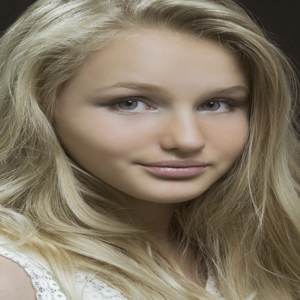

In [17]:
# Reading the source image from the specified url
source = Image.open(BytesIO(requests.get('https://images.unsplash.com/photo-1612058078343-aec0f8fac008?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=985&q=80').content))
source = source.resize((300, 300))
source

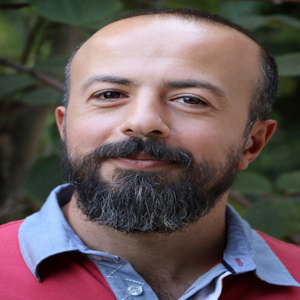

In [15]:
# Reading the destination image from the specified url
destination = Image.open(BytesIO(requests.get('https://images.unsplash.com/photo-1545167622-3a6ac756afa4?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1012&q=80').content))
destination = destination.resize((300, 300))
destination

In [19]:
# Convert source image to numpy array so that the model can be applied to it
source_numpy = np.array(source)

# Convert source image to grayscale for better results
source_gray = cv2.cvtColor(source_numpy, cv2.COLOR_BGR2GRAY)

# Create mask image similar to source image
masked_source = np.zeros_like(source_gray)

# Convert destination image to numpy array so that the model can be applied to it
destination_numpy = np.array(destination)

# Convert destination image to grayscale for better results
destination_gray = cv2.cvtColor(destination_numpy, cv2.COLOR_BGR2GRAY)

In [20]:
# Load the Face Detector found in Dlib
face_detector = dlib.get_frontal_face_detector()

# Load the face landmarks predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Create the height, width and channels for creating an empty image which is like the destination image
height, width, channels = destination_numpy.shape
new_destination_numpy = np.zeros((height, width, channels), np.uint8)

In [21]:
# Source image
faces = face_detector(source_gray)
for face in faces:
  
  # Get the face landmarks
  face_landmarks = predictor(source_gray, face)

  # Create an array that will store the points
  landmark_points = []
  for n in range(0, 68):
    x = face_landmarks.part(n).x
    y = face_landmarks.part(n).y

    # store the face_landmark points in an array
    landmark_points.append((x, y))

  points = np.array(landmark_points, np.int32)
  convexhull = cv2.convexHull(points)
  cv2.fillConvexPoly(masked_source, convexhull, 255)
  
  face_source = cv2.bitwise_and(source_numpy, source_numpy, mask=masked_source)

  # Delaunay triangulation
  rect = cv2.boundingRect(convexhull)
  subdiv = cv2.Subdiv2D(rect)
  subdiv.insert(landmark_points)
  triangles = subdiv.getTriangleList()
  triangles = np.array(triangles, dtype=np.int32)

  indexes_triangles = []
  
  for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = extract_index_nparray(index_pt1)

    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = extract_index_nparray(index_pt2)

    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = extract_index_nparray(index_pt3)

    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
      triangle = [index_pt1, index_pt2, index_pt3]
      indexes_triangles.append(triangle)

In [22]:
# Destination image
faces_destination = face_detector(destination_gray)
for face in faces_destination:
  landmarks = predictor(destination_gray, face)
  landmark_points_destination = []
  for n in range(0, 68):
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    landmark_points_destination.append((x, y))

  points_destination = np.array(landmark_points_destination, np.int32)
  convexhull2 = cv2.convexHull(points_destination)

In [23]:
# Masking the images
lines_space_mask = np.zeros_like(source_gray)
lines_space_new_face = np.zeros_like(destination_numpy)

In [25]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
  # Triangulation of the first face
  tr1_pt1 = landmark_points[triangle_index[0]]
  tr1_pt2 = landmark_points[triangle_index[1]]
  tr1_pt3 = landmark_points[triangle_index[2]]
  triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

  rect1 = cv2.boundingRect(triangle1)
  (x, y, w, h) = rect1
  cropped_triangle = source_numpy[y: y + h, x: x + w]
  cropped_trl_mask = np.zeros((h, w), np.uint8)

  points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y], 
                     [tr1_pt2[0] - x, tr1_pt2[1] - y], 
                     [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)
  
  cv2.fillConvexPoly(cropped_trl_mask, points, 255)

  # Lines space
  cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
  cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
  cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
  lines_space = cv2.bitwise_and(source_numpy, source_numpy, mask=lines_space_mask)

  # Triangulation of second face
  tr2_pt1 = landmark_points_destination[triangle_index[0]]
  tr2_pt2 = landmark_points_destination[triangle_index[1]]
  tr2_pt3 = landmark_points_destination[triangle_index[2]]
  triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

  rect2 = cv2.boundingRect(triangle2)
  (x, y, w, h) = rect2
  cropped_tr2_mask = np.zeros((h, w), np.uint8)

  points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y], 
                     [tr2_pt2[0] - x, tr2_pt2[1] - y], 
                     [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)
  
  cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

  # Warp triangles
  points = np.float32(points)
  points2 = np.float32(points2)
  M = cv2.getAffineTransform(points, points2)
  warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
  warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

  # Reconstructing destination face
  destinationImg_new_face_rect_area = new_destination_numpy[y: y + h, x: x + w]
  destinationImg_new_face_rect_area_gray = cv2.cvtColor(destinationImg_new_face_rect_area, cv2.COLOR_BGR2GRAY)
  _, mask_triangles_designed = cv2.threshold(destinationImg_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
  warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

  destinationImg_new_face_rect_area = cv2.add(destinationImg_new_face_rect_area, warped_triangle)
  new_destination_numpy[y: y + h, x: x + w] = destinationImg_new_face_rect_area

In [26]:
# Face-Swap
destination_face_mask = np.zeros_like(destination_gray)
destination_head_mask = cv2.fillConvexPoly(destination_face_mask, convexhull2, 255)
destination_face_mask = cv2.bitwise_not(destination_head_mask)

In [27]:
# Replace the face of the destination image with the face of the source image
destination_head_no = cv2.bitwise_and(destination_numpy, destination_numpy, mask=destination_face_mask)
result = cv2.add(destination_head_no, new_destination_numpy)

In [38]:
# Adjust the color so the source image fits the destination image
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, np.array(destination), destination_head_mask, center_face2, cv2.NORMAL_CLONE)

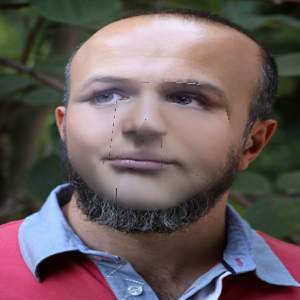

In [39]:
# Print the image
Image.fromarray(seamlessclone).convert('RGB')

### Source Image has been swapped with the destination image!